# Avaliador de Ações




In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from dotenv import dotenv_values
from os import system
from os.path import abspath

envVals = dotenv_values('.env')

def despine(ax):
  # Hiding spines
  ax.spines['right'].set_visible(False)
  ax.spines['top'].set_visible(False)

  # Setting
  ax.yaxis.set_ticks_position('left')
  ax.xaxis.set_ticks_position('bottom')


In [3]:
# Fazendo busca dos dados do ticker

system(f"node ./scripts/getData.js {envVals['TICKER']}")

(node:35259) Warning: Setting the NODE_TLS_REJECT_UNAUTHORIZED environment variable to '0' makes TLS connections and HTTPS requests insecure by disabling certificate verification.
(Use `node --trace-warnings ...` to show where the warning was created)


0

In [4]:
# Abrindo indicadores em um DataFrame
dataPath = abspath('./data') + '/' + envVals['TICKER'] + '.json'
indicadoresDf = pd.read_json(dataPath)

# Abrindo histórico de cotações da ação em um segundo DataFrame
yahooTicker = envVals['TICKER'] + '.SA'

tk = yf.Ticker(yahooTicker)
tickerDf = tk.history('5y')


## Histórico de Indicadores Fundamentalistas

Os gráficos à seguir tem a intenção de detalhar o histórico de alguns indicadores fundamentalistas referentes ao Ticker em análise. (P/L, DY, VPA, P/VP) 

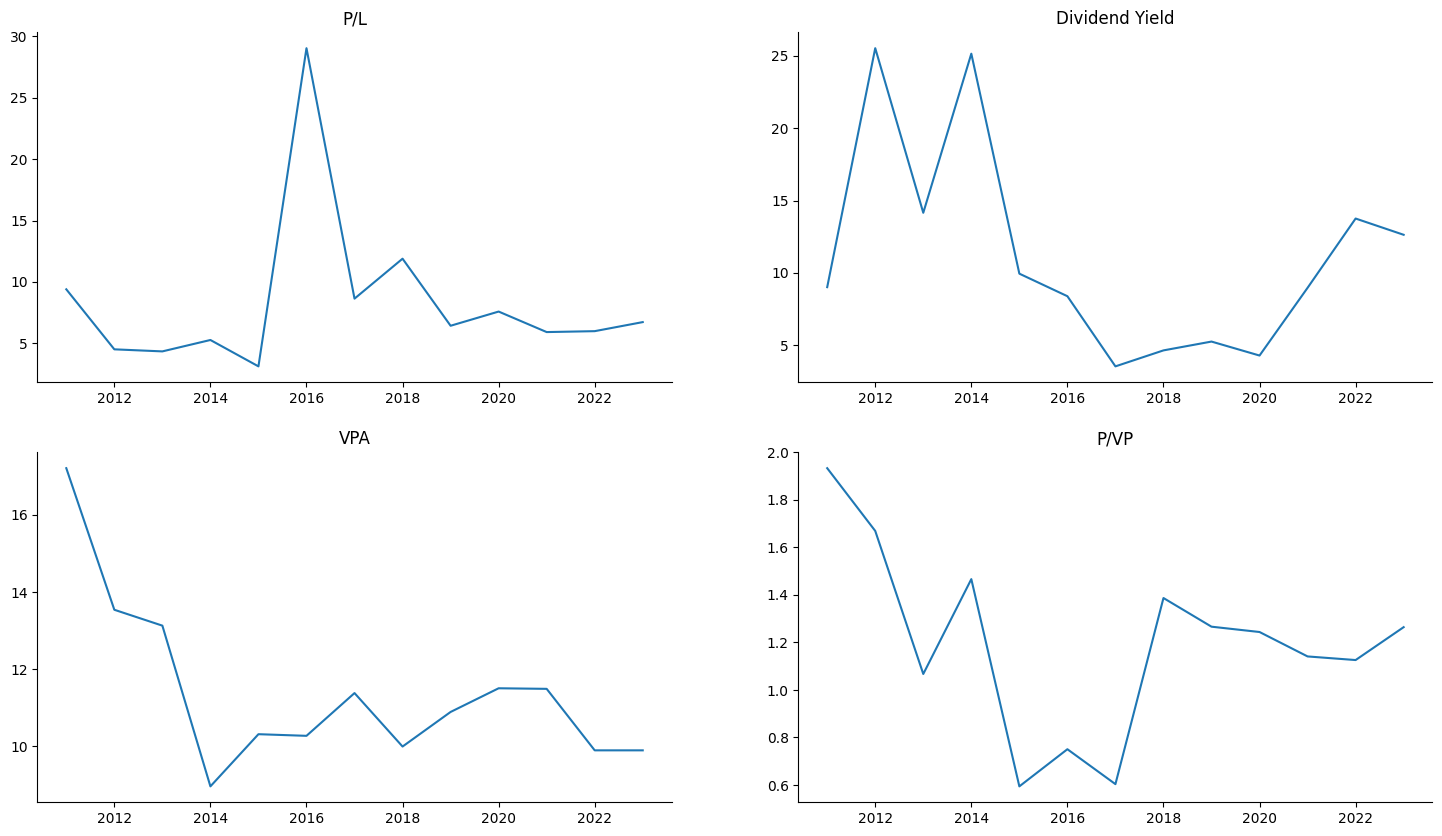

In [22]:
valores = [pd.DataFrame(indicadoresDf['P/L']['series']), pd.DataFrame(indicadoresDf['Dividend Yield']['series']),pd.DataFrame(indicadoresDf['VPA']['series']), pd.DataFrame(indicadoresDf['P/VP']['series'])]

indexes = ['P/L', 'Dividend Yield', 'VPA', 'P/VP']

fig, vax = plt.subplots(2, 2)

fig.set_figheight(10)
fig.set_figwidth(18)

for ax, data, name in zip(vax.flat, valores, indexes):
    
    despine(ax)
    ax.set_title(f'{name}')
    ax.plot(data['year'], data['value'])


plt.show()

## Cálculo do valor pelo método de Graham

O método de Graham utiliza de dois indicadores fundamentalistas: $LPA$ e $VPA$, para realizar o cálculo do "Valor Justo" de uma ação, ou seja, o valor que ela deveria ter de acordo com seus indicadores fundamentalistas. O cálculo é realizado através da seguinte fórmula:

$$
\sqrt{22.5 * LPA * VPA}
$$

Além disso, é calculada também uma margem de segurança em relação ao preço ideal de uma ação, que é um decréscimo de 15-30% do valor ideal. O valor de margem de segurança é subjetivo, e deve variar de acordo com a empresa.

In [6]:
graham = np.sqrt(22.5 * indicadoresDf['VPA']['currentValue'] * indicadoresDf['LPA']['currentValue'])
safetyMargin = graham - float(envVals['SAFETY']) * graham
safetypercent = float(envVals['SAFETY']) * 100

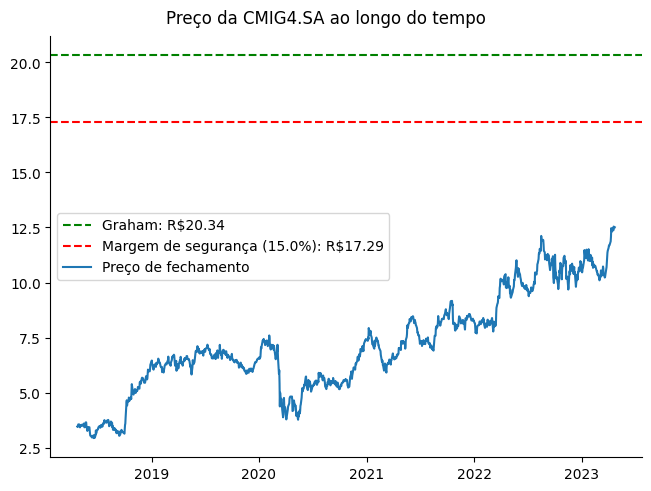

In [7]:

fig, ax= plt.subplots(1, 1, constrained_layout =True)

# Plotando valor de Graham atual vs COtação
ax.axhline(y=graham, color='green', linestyle='dashed', label=f'Graham: R${graham:.2f}')
ax.axhline(y=safetyMargin, color='red', linestyle='dashed', label=f'Margem de segurança ({safetypercent}%): R${safetyMargin:.2f}')
ax.plot(tickerDf['Close'], label='Preço de fechamento')

despine(ax)

fig.suptitle(f"Preço da {yahooTicker} ao longo do tempo")

ax.legend()